# Lab4
### Import nesssary model

In [1]:
import pandas as pd
from pandas import Series, DataFrame
import numpy as np
from IPython.display import Image
np.set_printoptions(precision = 3)

### Load data

In [2]:
data = pd.read_csv("jester-data-1.csv", header=None)
#del data["0"]
#d = data.to_latex()
#text_file = open("Output_lab4_test.txt", "w")
#text_file.write(d)
#text_file.close()

In [3]:
data.columns
del data[data.columns[0]]

In [4]:
data.head()

,1,2,3,4,5,6,7,8,9,10,...,91,92,93,94,95,96,97,98,99,100
0,-7.82,8.79,-9.66,-8.16,-7.52,-8.50,-9.85,4.17,-8.98,-4.76,...,2.82,99.00,99.00,99.00,99.00,99.00,-5.63,99.00,99.00,99.00
1,4.08,-0.29,6.36,4.37,-2.38,-9.66,-0.73,-5.34,8.88,9.22,...,2.82,-4.95,-0.29,7.86,-0.19,-2.14,3.06,0.34,-4.32,1.07
2,99.00,99.00,99.00,99.00,9.03,9.27,9.03,9.27,99.00,99.00,...,99.00,99.00,99.00,9.08,99.00,99.00,99.00,99.00,99.00,99.00
3,99.00,8.35,99.00,99.00,1.80,8.16,-2.82,6.21,99.00,1.84,...,99.00,99.00,99.00,0.53,99.00,99.00,99.00,99.00,99.00,99.00
4,8.50,4.61,-4.17,-5.39,1.36,1.60,7.04,4.61,-0.44,5.73,...,5.19,5.58,4.27,5.19,5.73,1.55,3.11,6.55,1.80,1.60


### Prepare the dataset

In [5]:
user_ratings = data.values
#user_ratings = data.values[0:100]

In [6]:
user_ratings_vali = np.zeros(user_ratings.shape) + 99.0
user_ratings_copy = user_ratings.copy() 
count = 0
loc_log = []
for x in range(0,user_ratings.shape[0]):
    for y in range(0,user_ratings.shape[1]):
        if (user_ratings_copy[x,y]!=99.0):
            if (np.random.random() > 0.9):
                count += 1
                temp = user_ratings_copy[x,y]
                user_ratings_copy[x,y] = user_ratings_vali[x,y]
                user_ratings_vali[x,y] = temp
                loc_log.append((x,y))
                #print(temp)
print(user_ratings_vali,'\n', count,'\n', count/(user_ratings.shape[0]*user_ratings.shape[1]))

[[-7.82 99.   99.   ... 99.   99.   99.  ]
 [99.   99.   99.   ...  0.34 99.   99.  ]
 [99.   99.   99.   ... 99.   99.   99.  ]
 ...
 [99.   99.   99.   ... 99.   99.   99.  ]
 [99.   99.   99.   ... 99.   99.   99.  ]
 [99.   99.   99.   ... 99.   99.   99.  ]] 
 181047 
 0.0724680782932394


In [7]:
len(loc_log)

181047

### Prepare the predicte matrix

In [8]:
n_features = 100
latent_user_preferences = np.random.random((user_ratings.shape[0], n_features))
latent_item_features = np.random.random((user_ratings.shape[1],n_features))

In [9]:
print('user_ratings.shape:           ',user_ratings.shape)
print('latent_user_preferences.shape:',latent_user_preferences.shape)
print('latent_item_features.shape:   ',latent_item_features.shape)

user_ratings.shape:            (24983, 100)
latent_user_preferences.shape: (24983, 100)
latent_item_features.shape:    (100, 100)


In [10]:
user_ratings, user_ratings.shape

(array([[-7.82,  8.79, -9.66, ..., 99.  , 99.  , 99.  ],
        [ 4.08, -0.29,  6.36, ...,  0.34, -4.32,  1.07],
        [99.  , 99.  , 99.  , ..., 99.  , 99.  , 99.  ],
        ...,
        [99.  , 99.  , 99.  , ..., 99.  , 99.  , 99.  ],
        [99.  , 99.  , 99.  , ..., 99.  , 99.  , 99.  ],
        [ 2.43,  2.67, -3.98, ..., 99.  , 99.  , 99.  ]]), (24983, 100))

In [11]:
np.random.random()

0.8677855167201202

### Training function

In [12]:
    train_mse_loglist = []
    test_mse_loglist = []
    best_latent_user_preferences = latent_user_preferences.copy()
    best_latent_item_features = latent_item_features.copy()
    best_test_mse = 99999.0
    best_loc = 0

In [13]:
def predict_rating(user_id,item_id):
    """ Predict a rating given a user_id and an item_id.
    """
    user_preference = latent_user_preferences[user_id]
    item_preference = latent_item_features[item_id]
    return user_preference.dot(item_preference)  #linear

def train(user_id, item_id, rating,alpha = 0.0001):
    
    #print (item_id)
    prediction_rating = predict_rating(user_id, item_id)
    err =  ( prediction_rating- rating );
    #print (err)
    user_pref_values = latent_user_preferences[user_id][:]
    latent_user_preferences[user_id] -= alpha * err * latent_item_features[item_id]
    latent_item_features[item_id] -= alpha * err * user_pref_values
    return err
    


def sgd(iterations = 300000):
    """ Iterate over all users and all items and train for 
        a certain number of iterations
    """
    global best_latent_user_preferences
    global best_latent_item_features
    global best_test_mse
    global best_loc
    err_mse_log = 99999.0
    for iteration in range(0,iterations):
        error = []
        vali_err = []
        for user_id in range(0,latent_user_preferences.shape[0]):
            for item_id in range(0,latent_item_features.shape[0]):
                rating = user_ratings_copy[user_id][item_id]
                if(rating != 99):
                    err = train(user_id,item_id,rating)
                    error.append(err)
                    #print(rating)
        mse = (np.array(error) ** 2).mean()
        train_mse_loglist.append(mse)
        err_mse = mse - err_mse_log
        #if (err_mse>0):
        #    print(mse, err_mse, err_mse_log)
        #    break
        err_mse_log = mse
        for loc in loc_log:
            vali_err.append(user_ratings_vali[loc[0]][loc[1]]-latent_user_preferences[loc[0]].dot(latent_item_features[loc[1]]))
        test_mse = (np.array(vali_err) ** 2).mean()
        test_mse_loglist.append(test_mse)
        if (test_mse < best_test_mse):
            best_test_mse = test_mse
            best_latent_user_preferences = latent_user_preferences.copy()
            best_latent_item_features = latent_item_features.copy()
            best_loc = iteration
        if (iteration > best_loc+100):
            break
        #print(iteration)
        #if(iteration%100 == 0 ):
        print (iteration, ':=', mse, err_mse, test_mse)
                    
                    
    

In [14]:
sgd()

0 := 32.59674007483621 -99966.40325992517 25.421635468717085
1 := 25.206193687379947 -7.390546387456265 25.29983365144494
2 := 25.044298527468737 -0.16189515991121084 25.208868285785243
3 := 24.917297257649153 -0.12700126981958348 25.1341418582466
4 := 24.80817494967055 -0.1091223079786019 25.063814230112335
5 := 24.7025998673821 -0.1055750822884498 24.986569901491507
6 := 24.58648028465522 -0.11611958272688128 24.88979831853867
7 := 24.443962397103803 -0.14251788755141703 24.75801441330038
8 := 24.255836364207845 -0.18812603289595842 24.571728109893005
9 := 23.99883390168425 -0.2570024625235945 24.30755127942526
10 := 23.647033328780985 -0.35180057290326516 23.941099453477545
11 := 23.177263572903357 -0.46976975587762837 23.454613612407552
12 := 22.579840629877104 -0.5974229430262525 22.84951643452477
13 := 21.87217876985134 -0.7076618600257625 22.158552813451458
14 := 21.10597089253461 -0.7662078773167309 21.445685358341926
15 := 20.356286434529288 -0.7496844580053228 20.785556877726

KeyboardInterrupt: 

In [15]:
del train_mse_loglist[0]

In [16]:
best_loc

67

In [18]:
import seaborn as sns

In [32]:
plotdata1 = DataFrame(np.vstack((np.arange(np.array(train_mse_loglist).shape[0]), train_mse_loglist)).T, columns=['iterations', 'train_MSE'])

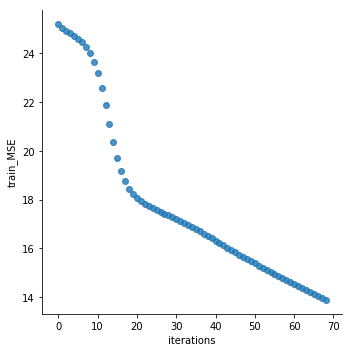

In [34]:
sns_plot = sns.lmplot(plotdata1.columns[0], plotdata1.columns[1], data=plotdata1, fit_reg=False)
sns_plot.savefig("Fulltext_predictions_trainMSE_%df_%d.png"%(n_features, best_loc), bbox_inches='tight')
sns_plot

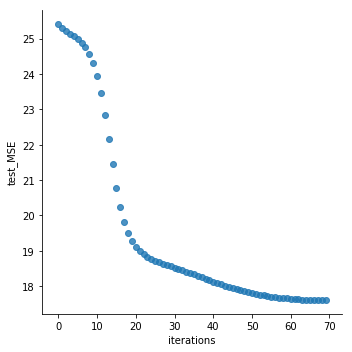

In [35]:
plotdata1 = DataFrame(np.vstack((np.arange(np.array(test_mse_loglist).shape[0]), test_mse_loglist)).T, columns=['iterations', 'test_MSE'])
sns_plot = sns.lmplot(plotdata1.columns[0], plotdata1.columns[1], data=plotdata1, fit_reg=False)
sns_plot.savefig("Fulltext_predictions_testMSE_%df_%d.png"%(n_features, best_loc), bbox_inches='tight')
sns_plot

In [22]:
min(test_mse_loglist), test_mse_loglist.index(min(test_mse_loglist)), train_mse_loglist[test_mse_loglist.index(min(test_mse_loglist))+1]

(17.610293059824947, 67, 13.882302603242078)

In [23]:
min(train_mse_loglist), train_mse_loglist.index(min(train_mse_loglist)), 

(13.882302603242078, 68)

In [24]:
latent_user_preferences

array([[ 0.249,  0.501,  0.99 , ...,  0.816, -0.069,  0.611],
       [ 0.07 , -0.037,  0.064, ...,  0.657,  0.803,  0.002],
       [ 0.596,  0.947,  0.378, ...,  0.412,  0.359,  0.829],
       ...,
       [ 0.03 ,  0.561,  0.542, ...,  0.907,  0.525,  0.751],
       [ 0.897,  0.434,  0.924, ...,  0.374,  0.201,  0.743],
       [ 0.575,  0.583,  0.435, ...,  0.387,  0.428,  0.484]])

In [25]:
predictions = best_latent_user_preferences.dot(best_latent_item_features.T)
predictions

array([[-3.347, -1.788, -6.097, ..., -1.98 , -4.86 , -5.556],
       [ 5.878,  2.864,  8.361, ...,  2.444,  1.071,  5.627],
       [ 6.566,  3.902,  8.695, ...,  6.193,  6.918,  7.755],
       ...,
       [-1.052, -0.032, -1.17 , ...,  0.844, -3.173,  1.9  ],
       [ 1.302,  1.294, -0.074, ..., -2.966, -3.363, -1.56 ],
       [ 2.53 ,  2.779,  1.107, ...,  5.602,  6.159,  4.456]])

In [26]:
err = []
for t in range(0, len(loc_log)):
    #print(predictions[loc_log[t][0],loc_log[t][1]], best_latent_user_preferences[loc_log[t][0]].dot(best_latent_item_features[loc_log[t][1]]), user_ratings_vali[loc_log[t][0]][loc_log[t][1]])
    err.append(best_latent_user_preferences[loc_log[t][0]].dot(best_latent_item_features[loc_log[t][1]])-user_ratings_vali[loc_log[t][0]][loc_log[t][1]])
mse2 = (np.array(err) ** 2).mean()
print(mse2)

17.610293059824947


In [ ]:
vali_err = []
for loc in loc_log:
    vali_err.append(user_ratings_vali[loc[0]][loc[1]]-best_latent_user_preferences[loc[0]].dot(best_latent_item_features[loc[1]]))
test_mse = (np.array(vali_err) ** 2).mean()
print (test_mse)

In [28]:
best_test_mse

17.610293059824947

In [ ]:
values = [zip(user_ratings_copy[i], predictions[i]) for i in range(0,predictions.shape[0])]
comparison_data = pd.DataFrame(values)
comparison_data.columns = data.columns
comparison_data.applymap(lambda x: "(%2.3f|%2.3f)"%(x[0],x[1]))
#comparison_data.head()

In [27]:
values = [zip(user_ratings_vali[i], predictions[i]) for i in range(0,predictions.shape[0])]
comparison_data = pd.DataFrame(values)
comparison_data.columns = data.columns
comparison_data.applymap(lambda x: ["(%2.3f|%2.3f)"%(x[0],x[1])])

,1,2,3,4,5,6,7,8,9,10,...,91,92,93,94,95,96,97,98,99,100
0,[(-7.820|-3.347)],[(99.000|-1.788)],[(99.000|-6.097)],[(99.000|-10.836)],[(99.000|-3.004)],[(99.000|-3.241)],[(99.000|-5.938)],[(99.000|-1.979)],[(99.000|-9.251)],[(99.000|-4.624)],...,[(99.000|-1.360)],[(99.000|-3.424)],[(99.000|-2.119)],[(99.000|-4.586)],[(99.000|-3.744)],[(99.000|-2.799)],[(99.000|-2.162)],[(99.000|-1.980)],[(99.000|-4.860)],[(99.000|-5.556)]
1,[(99.000|5.878)],[(99.000|2.864)],[(99.000|8.361)],[(99.000|6.636)],[(99.000|1.855)],[(99.000|1.903)],[(-0.730|0.523)],[(99.000|-1.472)],[(99.000|6.455)],[(99.000|7.172)],...,[(99.000|3.276)],[(99.000|-1.087)],[(99.000|1.682)],[(99.000|4.709)],[(99.000|3.763)],[(99.000|1.564)],[(99.000|1.599)],[(0.340|2.444)],[(99.000|1.071)],[(99.000|5.627)]
2,[(99.000|6.566)],[(99.000|3.902)],[(99.000|8.695)],[(99.000|6.904)],[(9.030|5.269)],[(9.270|10.653)],[(99.000|3.393)],[(99.000|3.193)],[(99.000|9.551)],[(99.000|9.656)],...,[(99.000|8.871)],[(99.000|7.814)],[(99.000|7.285)],[(99.000|9.092)],[(99.000|7.853)],[(99.000|8.310)],[(99.000|7.454)],[(99.000|6.193)],[(99.000|6.918)],[(99.000|7.755)]
3,[(99.000|-0.489)],[(8.350|1.213)],[(99.000|1.965)],[(99.000|1.118)],[(99.000|3.056)],[(99.000|3.701)],[(99.000|-1.816)],[(99.000|-1.676)],[(99.000|-2.162)],[(99.000|1.787)],...,[(99.000|0.981)],[(99.000|2.680)],[(99.000|3.341)],[(99.000|-0.321)],[(99.000|1.569)],[(99.000|0.732)],[(99.000|1.824)],[(99.000|5.218)],[(99.000|-0.055)],[(99.000|4.772)]
4,[(99.000|3.647)],[(99.000|3.734)],[(99.000|4.913)],[(99.000|3.011)],[(99.000|1.046)],[(99.000|6.080)],[(99.000|0.947)],[(99.000|-3.958)],[(99.000|1.584)],[(99.000|2.845)],...,[(5.190|2.952)],[(5.580|2.274)],[(4.270|4.778)],[(99.000|2.024)],[(99.000|1.867)],[(99.000|2.411)],[(99.000|1.387)],[(99.000|6.745)],[(99.000|1.090)],[(99.000|7.308)]
5,[(-6.170|-3.068)],[(99.000|-6.185)],[(99.000|-3.947)],[(99.000|-6.362)],[(99.000|-4.832)],[(99.000|-6.643)],[(99.000|-2.982)],[(-0.870|-1.712)],[(99.000|-6.720)],[(99.000|-4.776)],...,[(99.000|-2.952)],[(99.000|-4.204)],[(99.000|-1.804)],[(99.000|-3.520)],[(99.000|-3.910)],[(99.000|-4.791)],[(99.000|-4.916)],[(99.000|-5.604)],[(99.000|-4.417)],[(99.000|-4.145)]
6,[(99.000|2.000)],[(99.000|4.043)],[(99.000|4.515)],[(99.000|1.090)],[(8.590|1.894)],[(99.000|4.447)],[(99.000|1.986)],[(99.000|-0.163)],[(99.000|0.714)],[(99.000|1.872)],...,[(99.000|4.907)],[(99.000|4.012)],[(99.000|4.971)],[(99.000|3.148)],[(99.000|2.987)],[(2.330|2.366)],[(99.000|4.378)],[(99.000|6.724)],[(99.000|3.875)],[(99.000|4.108)]
7,[(99.000|-1.887)],[(3.160|-2.218)],[(9.170|-1.114)],[(99.000|-3.899)],[(99.000|0.324)],[(99.000|-3.213)],[(99.000|0.586)],[(99.000|-1.196)],[(99.000|-4.346)],[(99.000|-1.770)],...,[(99.000|-1.577)],[(99.000|-2.244)],[(-0.100|-0.395)],[(99.000|-2.259)],[(99.000|-1.381)],[(99.000|-1.892)],[(99.000|-0.768)],[(99.000|-0.893)],[(99.000|-3.642)],[(99.000|-0.868)]
8,[(99.000|-1.567)],[(99.000|-4.016)],[(-9.420|-3.603)],[(-6.890|-4.077)],[(99.000|-5.109)],[(99.000|0.841)],[(99.000|-4.496)],[(-8.930|-2.552)],[(99.000|-2.438)],[(-1.600|-1.938)],...,[(4.370|0.929)],[(99.000|3.258)],[(99.000|4.314)],[(99.000|-1.425)],[(-0.290|2.380)],[(99.000|1.816)],[(99.000|-0.185)],[(99.000|-1.143)],[(99.000|0.158)],[(99.000|-4.173)]
9,[(99.000|6.370)],[(99.000|5.532)],[(99.000|6.278)],[(99.000|2.196)],[(99.000|3.571)],[(99.000|3.712)],[(99.000|2.925)],[(99.000|1.676)],[(99.000|4.446)],[(8.160|5.052)],...,[(99.000|6.287)],[(99.000|4.638)],[(99.000|5.761)],[(99.000|5.859)],[(99.000|4.279)],[(99.000|7.633)],[(99.000|7.508)],[(99.000|4.289)],[(99.000|5.398)],[(99.000|4.864)]


In [ ]:
mse


In [29]:
predictions

array([[-3.347, -1.788, -6.097, ..., -1.98 , -4.86 , -5.556],
       [ 5.878,  2.864,  8.361, ...,  2.444,  1.071,  5.627],
       [ 6.566,  3.902,  8.695, ...,  6.193,  6.918,  7.755],
       ...,
       [-1.052, -0.032, -1.17 , ...,  0.844, -3.173,  1.9  ],
       [ 1.302,  1.294, -0.074, ..., -2.966, -3.363, -1.56 ],
       [ 2.53 ,  2.779,  1.107, ...,  5.602,  6.159,  4.456]])

In [30]:
latent_item_features

array([[ 0.586, -0.122, -1.158, ...,  0.378,  0.318, -0.81 ],
       [ 0.595,  0.69 , -0.375, ...,  0.208,  0.386, -0.078],
       [ 0.3  ,  0.44 , -1.025, ...,  0.259,  0.992, -0.805],
       ...,
       [ 0.253, -0.551, -0.255, ...,  0.21 ,  0.884,  0.445],
       [ 0.533,  0.414, -0.979, ...,  0.128, -0.212,  0.092],
       [ 0.775, -0.364, -0.05 , ...,  0.462,  2.016,  0.328]])

In [31]:
np.savetxt("Fulltext_predictions_%df_%d.csv"%(n_features, best_loc), predictions, delimiter=",")
np.savetxt("Fulltext_latent_user_preferences_%df_%d.csv"%(n_features, best_loc), best_latent_user_preferences, delimiter=",")
np.savetxt("Fulltextlatent_item_features_%df_%d.csv"%(n_features, best_loc), best_latent_item_features, delimiter=",")